# <center>Audio Emotion classifier</center>
## <center>Part 1 - Data Exploration</center>


In [4]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

TESS = "TESS Toronto emotional speech set data/"
RAV = "audio_speech_actors_01-24/"
SAVEE = "ALL/"
CREMA = "AudioWAV/"

# # Run one example 
# dir_list = os.listdir(SAVEE)
# dir_list[0:5]

<a id="savee"></a>
##  <center> 1. SAVEE dataset <center>
The audio files are named in such a way that the prefix letters describes the emotion classes as follows:
- 'a' = 'anger'
- 'd' = 'disgust'
- 'f' = 'fear'
- 'h' = 'happiness'
- 'n' = 'neutral'
- 'sa' = 'sadness'
- 'su' = 'surprise' 

The original source has 4 folders each representing a speaker, but i've bundled all of them into one single folder and thus the first 2 letter prefix of the filename represents the speaker initials. Eg. 'DC_d03.wav' is the 3rd disgust sentence uttered by the speaker DC. It's  worth nothing that they are all male speakers only. This isn't an issue as we'll balance it out with the TESS dataset which is just female only. So lets check out the distribution of the emotions...

In [6]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

labels
male_neutral     120
male_angry        60
male_disgust      60
male_fear         60
male_happy        60
male_sad          60
male_surprise     60
Name: count, dtype: int64

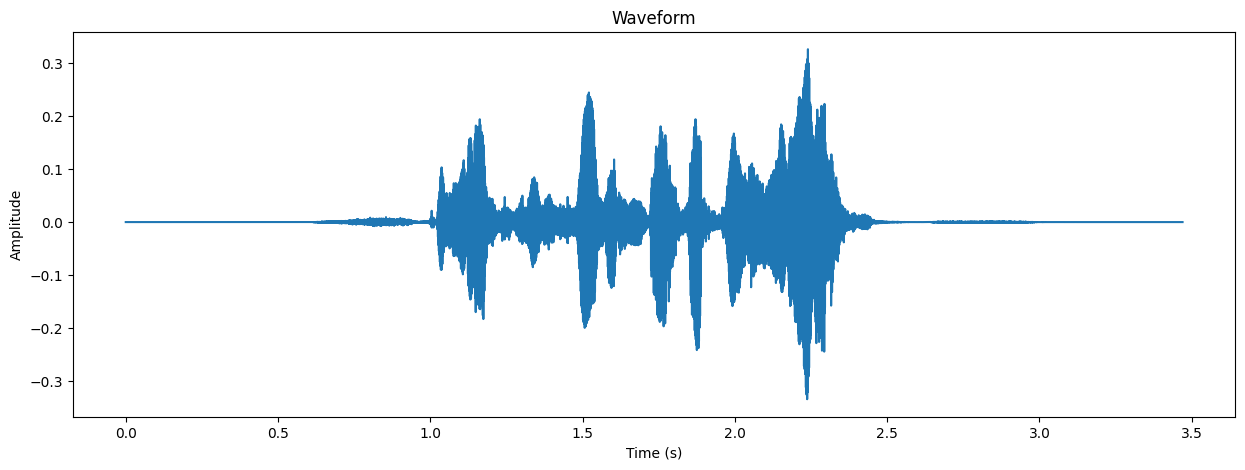

In [7]:
# Lets play a happy track
fname = SAVEE + 'DC_h11.wav'  
# Define the path to the audio file
fname = 'audio_speech_actors_01-24/Actor_14/03-01-06-02-02-02-14.wav'  

# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)

<a id="ravdess_load"></a>
###  Load the dataset 
Because of the way the entire data was packaged for us, and the format of the audio filename, there's a few more parsing steps required for the RAVDESS dataset compared to SAVEE 

In [8]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

<a id="ravdess_explore"></a>
### Explore the data
Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. And how different they are to SAVEE as we go along. Lets start with a fearful track

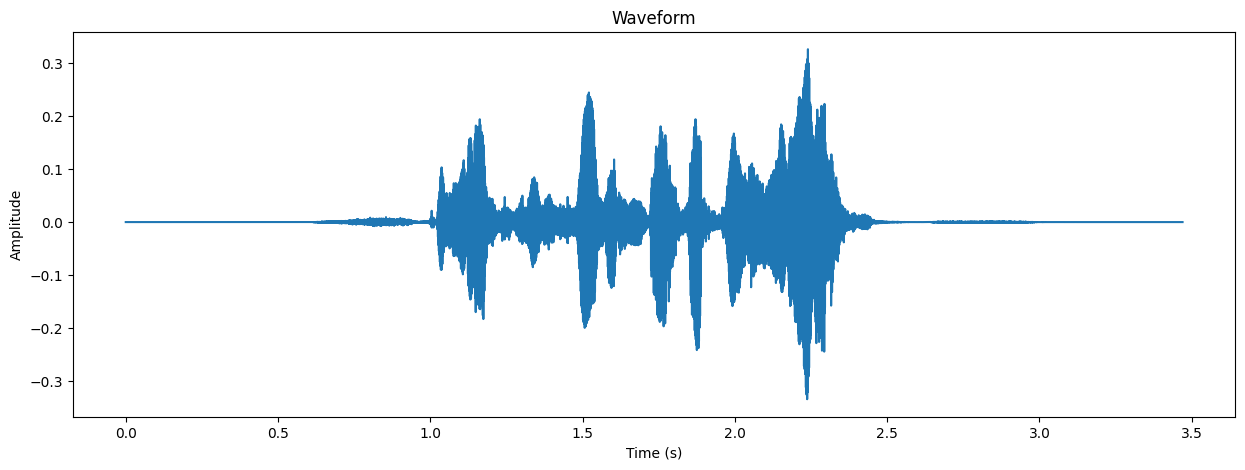

In [9]:
# Pick a fearful track

import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Define the path to the audio file
fname = 'audio_speech_actors_01-24/Actor_14/03-01-06-02-02-02-14.wav'  

# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)




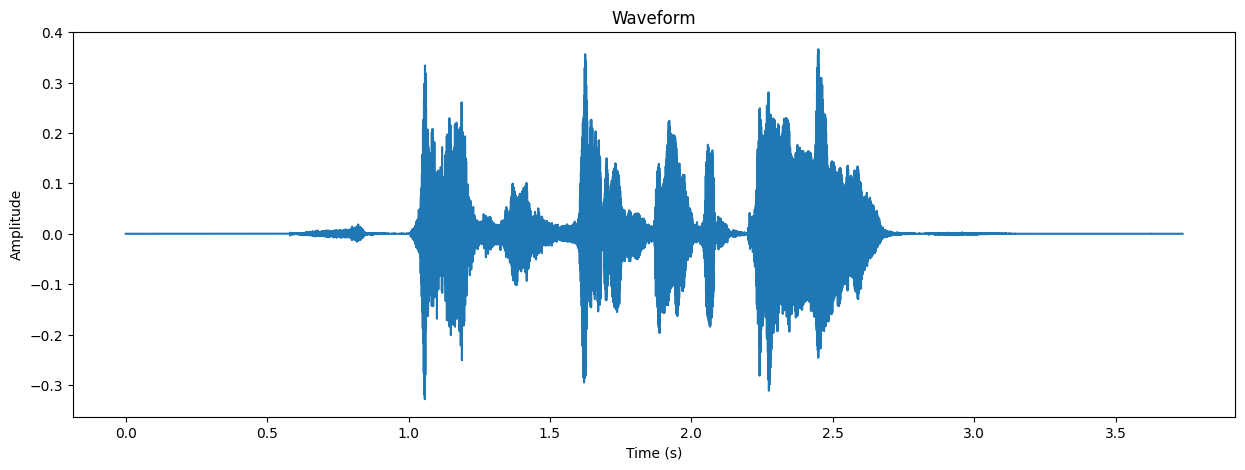

In [10]:
# Pick a happy track

import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Define the path to the audio file
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'    

# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)


<a id="tess_load"></a>
###  Load the dataset 
The speakers and the emotions are organised in seperate folders which is very convenient

In [11]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [12]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

labels
female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: count, dtype: int64

<a id="tess_explore"></a>
### Explore the data
400 files for each key emotion. Nice. So lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a fearful track

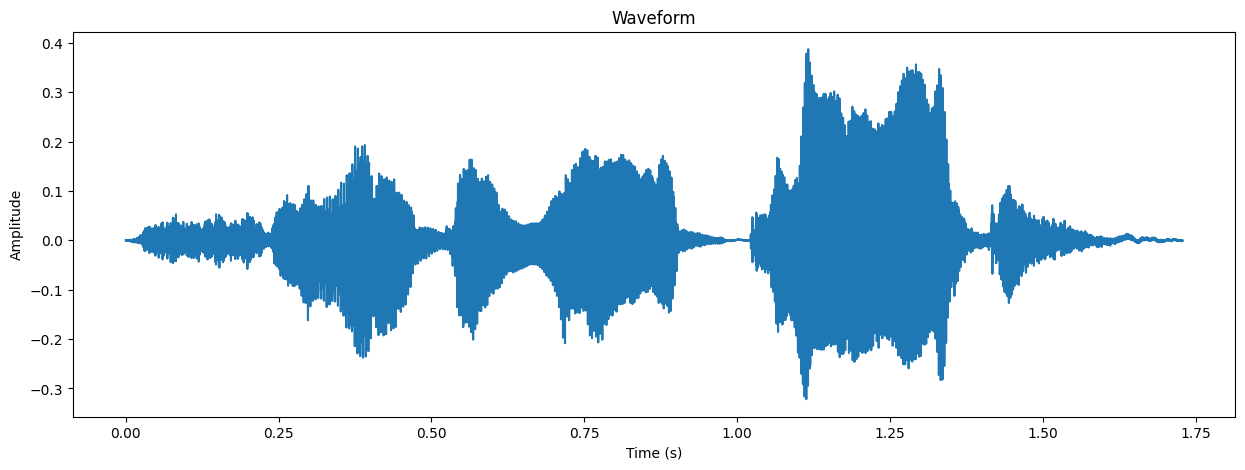

In [13]:
# lets play a fearful track 
fname = TESS + 'YAF_fear/YAF_dog_fear.wav' 

# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)

She sound almost the same as the female speaker from RAVDESS. Maybe when I have time I will go and investigate but for now,  the most important insight for me is that the expression of the emotions are very similar to RAVDESS and thus is a good indication it will serve as a good training dataset

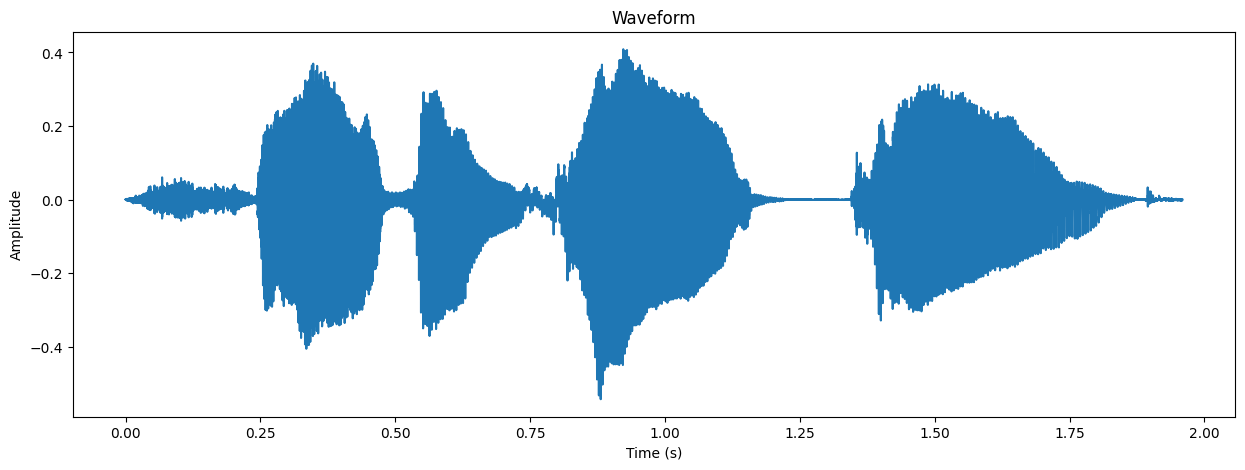

In [14]:
# lets play a happy track 
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav' 
# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)

<a id="crema"></a>
##  <center> 4. CREMA-D dataset <center>
Last but not least, CREMA dataset. Not much is known about this dataset and I don't see much usage of this in general in the wild. But its a very large dataset which we need. And it has a good variety of different speakers, apparently taken from movies. And the speakers are of different ethnicities. This is good. Means better generalisation when we do transfer learning. Very important

What we are missing from this dataset is the "surprise" emotion but no biggie, we can use the rest. But we have the rest. What's extra here is that it has different level of intensity of the emotion like RAVDESS. But we won't be using that for now

In [20]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [21]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

labels
male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: count, dtype: int64

<a id="crema_explore"></a>
### Explore the data
Ok so that's alot of data. Nice. Lets do the same thing again, take 2 audio files, play it and plot it to see what we're dealing with. Lets start with a happy track

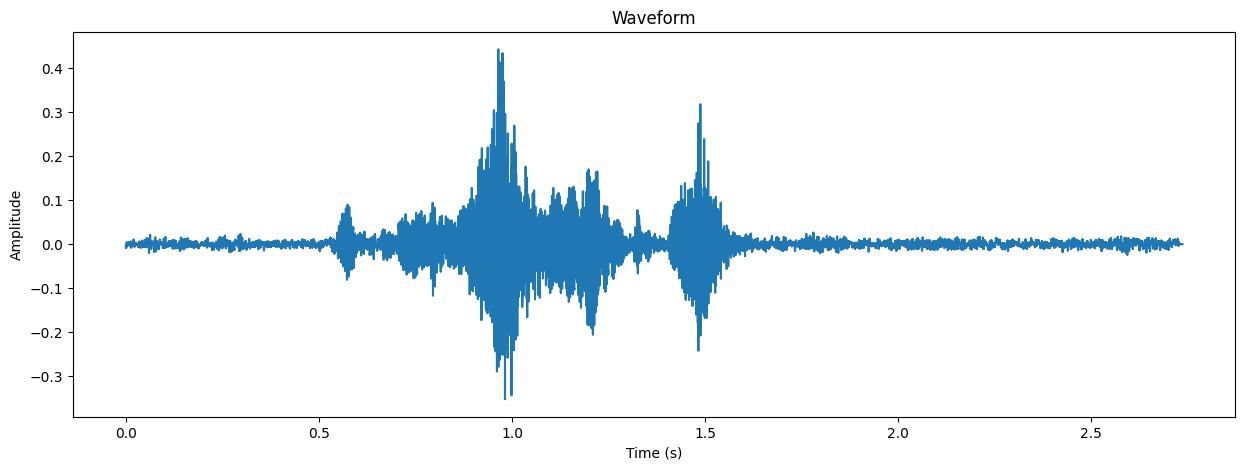

In [22]:
# use the well known Librosa library for this task 
fname = CREMA + '1012_IEO_HAP_HI.wav'  
# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)

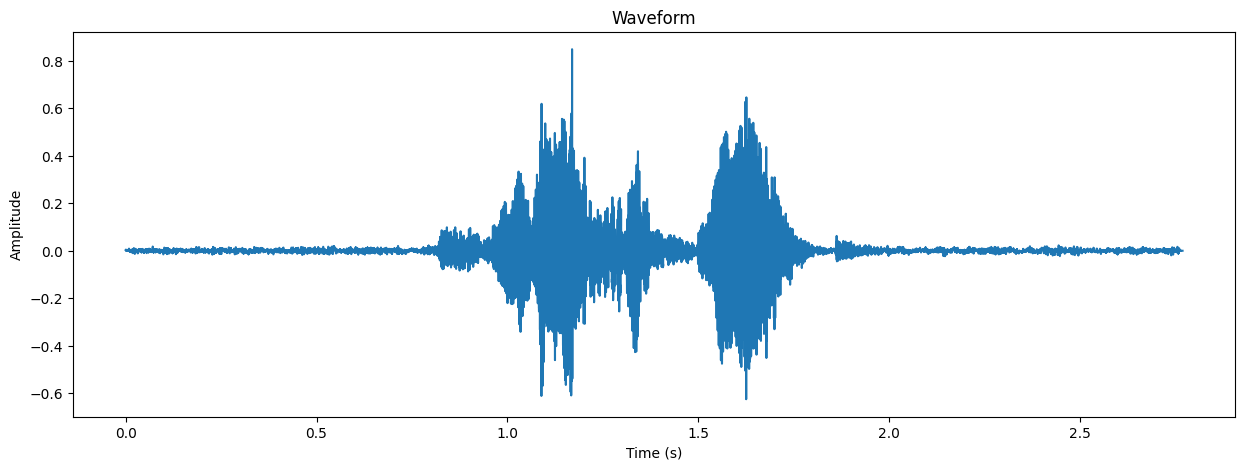

In [23]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
# Load the audio file
data, sampling_rate = librosa.load(fname)

# Calculate the duration of the audio in seconds
duration = len(data) / sampling_rate

# Create a time array for the x-axis
time = np.linspace(0, duration, len(data))

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(time, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the audio
ipd.Audio(fname)

In [24]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

labels
female_happy       1096
female_sad         1096
female_angry       1096
female_fear        1096
female_disgust     1096
female_neutral     1056
male_neutral        839
male_angry          827
male_disgust        827
male_fear           827
male_happy          827
male_sad            827
female_surprise     496
male_surprise       156
Name: count, dtype: int64
